# Detection of Malware and Adversaries

__TODO:__ Rewrite this to match what actually happened
1. table of contents
2. Make sure headings are properly indented

## Introduction

The goal of this tutorial is to use various data science techniques coupled with machine learning in order to create models that can detect and categorize adversaries and the techniques they use when hacking into computer networks.

The first portion of this tutorial will attempt to detect "commercial" malware, this is malware developed by criminals with the goal of either stealing money, or joining the computer to a larger botnet (access to the computing resources of this botnet is usually sold and used to perform large-scale denial of service attacks (DDOS) such as the case of [mirai](https://en.wikipedia.org/wiki/Mirai_(malware)). Commercial malware does not usually attempt to evade detections, and leaves a very large footprint on the system. I will attempt to train a model to detect the footprint left by this malware

The second portion of this tutorial will attempt to detect and classify the activity of nation state actors. These are known as [advanced persistent threats](https://en.wikipedia.org/wiki/Advanced_persistent_threat) (APTs). These groups of highly skilled and efficient attackers usually gain access into networks using highly target e-mails (spear phishing). Once a victim opens the e-mail and the attached file or clicks the attached link, a remote access trojan will be installed on the machine which will give the APT access to the network. Once access has been gained, these groups will attempt to evade detection as much as possible by leveraging existing applications pre-installed with windows. This is the exact type of activity I will attempt to detect.

This tutorial will work completely in a windows enviroment.

Our analysis will be leveraging domain knowledge of malware analysis and intrusion detection. Since this tutorial is aimed to be self-contained, please read the [following description](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon#events) of sysmon event types. This will provide a brief description into why we are pulling these specific logs from the virtual machine we will setup.

## Required Tools

* Python 3 and the science stack (numpy, pandas, sklearn, etc)
    * A full list of libraries used is available in `requirements.txt` in the github repository.
* VMWare Fusion
* Windows 7 ISO

# 1. Enviroment Setup

Before we start, we need a __safe enviroment__ to execute our malicious code and to emulate the adversaries we are trying to detect. This step is extremely important, as when analyzing malicious code we need to ensure that we do not put ourselves or anyone on our network in danger.

I highly recommend this [guide](https://blog.christophetd.fr/malware-analysis-lab-with-virtualbox-inetsim-and-burp/) for setting up a complete malware analysis virtual enviroment. This tutorial will only set up a single windows virtual machine, disconnected from the outside internet, with a few tools in order to generate data we are able to analyze. The environment setup below is in __no way a suitable malware analysis enviroment__.

It is important to following the following sections __in order__ in order to be able to properly configure the virtual machine.

### Virtual Machine Setup

This set of instruction assumes the usage of [VMWare Fusion 10](https://my.vmware.com/web/vmware/info?slug=desktop_end_user_computing/vmware_fusion/10_0).

To get started, we will be using a Windows 7 guest machine, as of 2017/12/07 this operating system is currently the [most used](https://en.wikipedia.org/wiki/Usage_share_of_operating_systems#Desktop_and_laptop_computers) in the world. An ISO image of the operating system is available from [here](https://www.microsoft.com/en-us/software-download/windows7). 

__Note!__: Make sure you set a password, this will make automating file transfers between our desktop and VM much easier.

The following [tutorial](https://kb.vmware.com/s/article/1011677) can be used to set up the initial virtual machine. 

Once that tutorial is completed, the following changes should be made to ensure the machine cannot communicate to the internet. Going to Virtual Machine -> Settings -> Network Adapter, uncheck the "connect network adapter" setting.


<img src="static/imgs/uncheck_network_adapter.png" width=400 height=400>

Again, this is the only virtual machine configuration step we will do in this tutorial, but is important enough to show explicitly how to do it.

### Windows Image Configuration


#### Sysmon

In order to log the various action malware does on our system, we will use [sysmon](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon). The reasoning for this is further explained in the Data Collection section. 

We will be using the [ion-storm](https://github.com/ion-storm/sysmon-config) sysmon configuration file. This configuration file does considerable whitelisting of activity from the machine, which will lower the amount of cleaning we will have to do in the long run. I have made one change in order to capture _any_ DNS request made (`<DestinationHostname condition="contains">.</DestinationHostname>`)

The copy used at the time of writing this tutorial is available under `etc/sysmon-config.xml` in the github repository.

To set up the sysmon agent, simply download sysmon and the configuration file from their respective links. Copy them over to the virtual machine (VM), open an administrative command prompt (start -> type cmd.exe -> right click, run as adminsitrator), and in the folder where sysmon and the configuration file are located run `sysmon.exe -accepteula -i sysmonconfig-export.xml`. This will launch the sysmon agent. You will be presented with the following messages if everything was executed correctly:

<img src="static/imgs/sysmon_installed.png" width=400 height=400>

### Snapshot

The primary reason we are using a VM to generate data (outside of the ability to segment it off the internet) is that we are able to take snapshots of the state of our VM. After a snapshot is created we can easily revert our machine to the state it was in the snapshot. This is important when dealing with malware since we want the ability to revert our analysis machine to a clean state in order to re-execute the malware. This is even more important in data science since we will have a baseline for all our logs, we will be able to extract only the logs from the machine after the snapshot occurs, thus giving us only the logs relevant to the actions or malware we are currently creating events for.

To take a snapshot simply do Virtual Machine -> Take Snapshot

<img src="static/imgs/take_snapshot.png" width=400 height=400>

I renamed my snapshot from the snapshot manager (Virtual Machine -> Take Snapshot) to "Sysmon installed" for clarity.

<img src="static/imgs/renamed_snapshot.png" width=200 height=200>



That's it! Our enviroment is set up for running some bad code and emulating some elite hackers!

# Data Collection

We need to be able to represent the actions performed on our virtual machine in some way. To accomplish this we will be collecting the log generate by Sysmon from our system.
 
1. __Sysmon logs__ $\rightarrow$ This is the agent we installed in part one, its logs are available at:
    * `C:\Windows\System32\winevt\Logs\Microsoft-Windows-Sysmon%4Operational.evtx`


## Fetching from VM

We can use the VMWare `vmrun` command to fetch files and send files to our analysis VM. This will make ingesting the sysmon logs much easier.

We can bring back a file 

```bash
| => vmrun -T ws copyFileFromGuestToHost -u <windows_username> -p <windows_password> <path_to_.vmx file> <file_on_vm> <name_on_our_pc>
```

So in order to grab back the sysmon file we can do:

```bash
| => vmrun -T ws copyFileFromGuestToHost -u admin -p admin "/Users/yampelo/Documents/Virtual Machines.localized/Windows 7 x64.vmwarevm" "C:\Windows\System32\winevt\Logs\Microsoft-Windows-Sysmon%4Operational.evtx" "Microsoft-Windows-Sysmon%4Operational.evtx"
```


These `.evtx` files are not standard text files, they are a special format and will require some parsing. The below shows the file header of the sysmon event log.


```shell
| => file Microsoft-Windows-Sysmon%4Operational.evtx
Microsoft-Windows-Sysmon%4Operational.evtx: MS Windows Vista Event Log, 1 chunks (no. 0 in use), empty, DIRTY

| => xxd -l 32 Microsoft-Windows-Sysmon%4Operational.evtx
00000000: 456c 6646 696c 6500 0000 0000 0000 0000  ElfFile.........
00000010: 0000 0000 0000 0000 0100 0000 0000 0000  ................
```

Under the hood, these log can be exported to XML files. Here is an example of what a single record from the event log looks like after being exported as XML.

```xml
<Event xmlns="http://schemas.microsoft.com/win/2004/08/events/event">
    <System>
        <Provider Name="Microsoft-Windows-Sysmon" Guid="{5770385f-c22a-43e0-bf4c-06f5698ffbd9}"></Provider>
        <EventID Qualifiers="">1</EventID>
        <Version>5</Version>
        <Level>4</Level>
        <Task>1</Task>
        <Opcode>0</Opcode>
        <Keywords>0x8000000000000000</Keywords>
        <TimeCreated SystemTime="2017-12-09 22:42:30.087566"></TimeCreated>
        <EventRecordID>16949</EventRecordID>
        <Correlation ActivityID="" RelatedActivityID=""></Correlation>
        <Execution ProcessID="1572" ThreadID="2064"></Execution>
        <Channel>Microsoft-Windows-Sysmon/Operational</Channel>
        <Computer>WIN-Q9JPOBVS95D</Computer>
        <Security UserID="S-1-5-18"></Security>
    </System>
    <EventData>
        <Data Name="UtcTime">2017-12-09 22:42:30.071</Data>
        <Data Name="ProcessGuid">{1a8edbb7-66d6-5a2c-0000-001085b78300}</Data>
        <Data Name="ProcessId">3908</Data>
        <Data Name="Image">C:\Windows\System32\wevtutil.exe</Data>
        <Data Name="CommandLine">wevtutil  cl Microsoft-Windows-Sysmon/Operational</Data>
        <Data Name="CurrentDirectory">C:\Users\admin\</Data>
        <Data Name="User">WIN-Q9JPOBVS95D\admin</Data>
        <Data Name="LogonGuid">{1a8edbb7-6699-5a2c-0000-002008f77900}</Data>
        <Data Name="LogonId">0x000000000079f708</Data>
        <Data Name="TerminalSessionId">2</Data>
        <Data Name="IntegrityLevel">High</Data>
        <Data Name="Hashes">SHA256=0DD7D2A9E56AE356591C1792EFB68A90FD76A7787E0B597FCBC4EF1FA514B601,IMPHASH=5CEEBCE34342598E6A5DC5278D7D430D</Data>
        <Data Name="ParentProcessGuid">{1a8edbb7-66c5-5a2c-0000-001087628300}</Data>
        <Data Name="ParentProcessId">2968</Data>
        <Data Name="ParentImage">C:\Windows\System32\cmd.exe</Data>
        <Data Name="ParentCommandLine">"C:\Windows\system32\cmd.exe" </Data>
    </EventData>
</Event>
```

##  `.evtx` Conversion

We will need to convert these `.evtx` files to XML then to something pandas can ingest.

We will be using a parsing library [python-evtx](https://github.com/williballenthin/python-evtx) to work with these files.

Let's try to convert a basic Sysmon event log into a dataframe. The sample file is available under `data/filetype_examples/Microsoft-Windows-Sysmon%4Operational.evtx`

In [1]:
import pprint
import Evtx.Evtx as evtx

def sysmon_evtx_to_dataframe(file):
    """Take an evtx file and convert it to a pandas dataframe
    
    Slightly modified from the below to return a dict instead of a string
    
    :param file: The .evtx file
    """
    
    def parse_record(record):
        """Convert an lxml record from sysmon into a dictionary
        :param record: lxml record from a sysmon evtx file
        """
        out = {}
        for node in record:
            parent = node.tag.split("}")[-1]
            for child in node:
                if parent == "EventData":
                    event_data_type = child.attrib['Name']
                    out[parent + "_" + event_data_type] = child.text
                else:
                    child_name = child.tag.split("}")[-1]
                    if len(child.attrib) > 0:
                        for k, v in child.attrib.items():
                            out[child_name + "_" + k] = v
                        out[child_name] = child.text
        return out
 
    
    events = []
    with evtx.Evtx(file) as log:
        for record in log.records():
            evt = parse_record(record.lxml())
            events.append(evt)
    return pd.DataFrame(events)

In [2]:
import pandas as pd
sysmon_df = sysmon_evtx_to_dataframe("data/filetype_examples/Microsoft-Windows-Sysmon%4Operational.evtx")

sysmon_df[sysmon_df.EventID == "1"].sample(1)

,Correlation,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_CommandLine,EventData_Configuration,EventData_ConfigurationFileHash,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,...,Execution,Execution_ProcessID,Execution_ThreadID,Provider,Provider_Guid,Provider_Name,Security,Security_UserID,TimeCreated,TimeCreated_SystemTime
6,None,,,C:\Windows\system32\ipconfig /renew,NaN,NaN,NaN,C:\Windows\system32\,NaN,NaN,...,None,624,2608,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-07 04:17:22.747120


In [3]:
sysmon_df.columns

Index(['Correlation', 'Correlation_ActivityID',
       'Correlation_RelatedActivityID', 'EventData_CommandLine',
       'EventData_Configuration', 'EventData_ConfigurationFileHash',
       'EventData_CreationUtcTime', 'EventData_CurrentDirectory',
       'EventData_DestinationHostname', 'EventData_DestinationIp',
       'EventData_DestinationIsIpv6', 'EventData_DestinationPort',
       'EventData_DestinationPortName', 'EventData_Details',
       'EventData_EventType', 'EventData_Hashes', 'EventData_Image',
       'EventData_Initiated', 'EventData_IntegrityLevel',
       'EventData_LogonGuid', 'EventData_LogonId',
       'EventData_ParentCommandLine', 'EventData_ParentImage',
       'EventData_ParentProcessGuid', 'EventData_ParentProcessId',
       'EventData_ProcessGuid', 'EventData_ProcessId', 'EventData_Protocol',
       'EventData_SchemaVersion', 'EventData_SourceHostname',
       'EventData_SourceIp', 'EventData_SourceIsIpv6', 'EventData_SourcePort',
       'EventData_SourcePortNam

It is pretty clear to see that our dataframe is very sparse. This is because sysmon has __21__ different event IDs that it monitors, and each of the event types has its own set of `EventData_*` keys to represent its specific data. Below is an array describing some of them. A full reference and description can be seen [here](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon#events): 


|ID|Event Type|
|--|--|
|1|Process creation
|3|Network connection
|5|Process terminated
|11|FileCreate
|12|RegistryEvent (Object create and delete)|
|13|RegistryEvent (Value Set)|
|14|RegistryEvent (Key and Value Rename)|


But otherwise we have now gotten over the main hurdle of the data collection step, we are now able to get events from our analysis VM into a pandas dataframe. 

I will define a function below that takes in a event ID and returns the event type. This will be useful when doing EDA to find out exactly what events occur a lot.


In [4]:
def event_type_from_id(event_id):
    """Get the event type from the ID
    
    :param event_id: Event ID to decode
    """
    
    event_id = str(event_id)
    types = {
        "1":"Process creation",
        "2":"A process changed a file creation time",
        "3":"Network connection",
        "4":"Sysmon service state changed",
        "5":"Process terminated",
        "6":"Driver loaded",
        "7":"Image loaded",
        "8":"CreateRemoteThread",
        "9":"RawAccessRead",
        "10":"ProcessAccess",
        "11":"FileCreate",
        "12":"RegistryEvent (Object create and delete)",
        "13":"RegistryEvent (Value Set)",
        "14":"RegistryEvent (Key and Value Rename)",
        "15":"FileCreateStreamHash",
        "16":"Sysmon config change",
        "17":"PipeEvent (Pipe Created)",
        "18":"PipeEvent (Pipe Connected)",
        "19":"WmiEvent (WmiEventFilter activity detected)",
        "20":"WmiEvent (WmiEventConsumer activity detected)",
        "21":"WmiEvent (WmiEventConsumerToFilter activity detected)",
        "255":"Error"
    }
    return types[event_id]

## 2. Creating "Good" Labeled Data

Since this is a classification problem, and we wish to know if we can classify activity on our machine as good activity, or as malicious activity, we will need to generate a set of data to represent the good activity.

In order to do this we can launch our VM and mimick normal usage. To do this I simply opened the VM, and installed the following:
1. Word
2. Powerpoint
3. Chrome
4. Spotify
5. Adobe Acrobat

We now have a normal workplace enviroment. But these installations are usually a one-time thing, and as such we don't want to create a baseline from that, instead of we want to create a baseline of day-to-day activity.

### Clearing baseline from system

Now that we have created a baseline, we don't want to re-analyze this baseline each time, we want to only ingest new data and classify it. This will also be useful when creating our labeled malicious data later on.

We can wipe the sysmon logs from the machine by running the following command through `cmd.exe`:

<img src="static/imgs/clear_sysmon_logs.png" width=500 height=500>

`wevtutil cl Microsoft-Windows-Sysmon/Operational`

This will wipe the `.evtx` file which Sysmon logs to. After doing this, take another snapshot of the VM. We do this so that we don't re-ingest the same dataset over and over. We only wish to classify a new set of data, had we not cleared the logs, we would constantly classify data we have already seen.

### Mimicking User Activity

Now that we have the machine set and the logs wiped, I reverted to my snapshot after tha clear, went to the CMSC320 class website, downloaded some PDFs, opened some powerpoints, created some word documents, and browsed the internet, watched some videos, downloaded some pictures.

The above should accuratly represent what an normal user does on their machine.

I then copied over the the event logs using the command mentioned in [the set up section](#Fetching-from-VM). The file is available under `data/baseline/baseline_good.evtx`. 

We can now take a look at the baseline data we have created

## Exploratoriy Data Analysis of Non-Malicious Data

Let's run it through our parser and do some EDA to determine if the baseline is good enough.

In [5]:
baseline = sysmon_evtx_to_dataframe("data/baseline/baseline_good.evtx")

baseline.shape

(1380, 54)

Looks like we have around 1380 events. That seems like a good chunk. Let's use seaborn to see what kind of data we have.

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

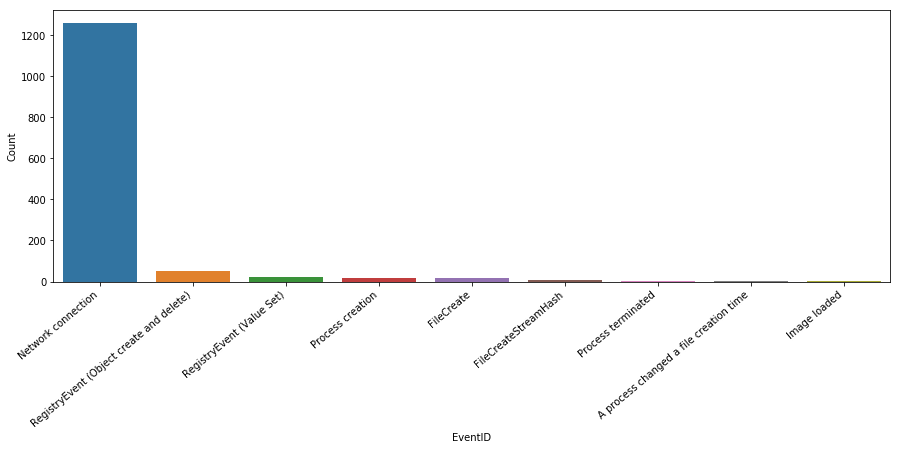

In [7]:
fig, ax = plt.subplots(figsize=(15,5))

count_by_event_id = pd.DataFrame(baseline['EventID'].value_counts())
count_by_event_id.rename(columns={"EventID": "Count"}, inplace=True)
count_by_event_id['EventID'] = count_by_event_id.index 
count_by_event_id['EventID'] = count_by_event_id['EventID'].apply(event_type_from_id) 
sns.barplot(x="EventID", y="Count", data=count_by_event_id, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show()

### RegistryEvent (Value Set) EDA

The first data type I wish to look at is the `RegistryEvent (Value Set)`

In [8]:
# Grab the event ID of registery ValueSet
registry_value_set = baseline[baseline['EventID'] == "13"] 

# Drop all rows that are empty for all events. This happens because of how spares our features are 
registry_value_set = registry_value_set.dropna(axis=1)

registry_value_set.head()

,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_Details,EventData_EventType,EventData_Image,EventData_ProcessGuid,EventData_ProcessId,EventData_TargetObject,EventData_UtcTime,EventID,EventID_Qualifiers,Execution_ProcessID,Execution_ThreadID,Provider_Guid,Provider_Name,Security_UserID,TimeCreated_SystemTime
11,,,0.0.0.0,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.551,13,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247
12,,,255.0.0.0,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.551,13,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247
13,,,255.255.255.255,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.551,13,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247
14,,,192.168.30.2,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.754,13,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.770247
15,,,192.168.30.2,SetValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.754,13,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.770247


Looks like we can see which process changes keys the most often

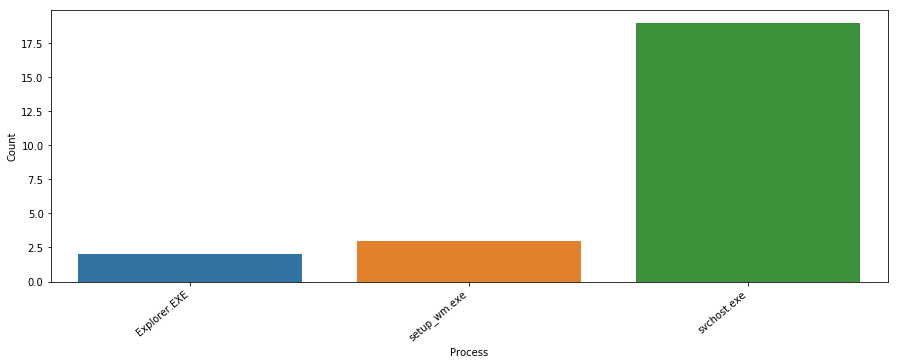

In [9]:
# Extract the process making the change from the EventData_Image Row
registry_value_set['Process'] = registry_value_set['EventData_Image'].apply(lambda x: x.split("\\")[-1])

# Let's see what registry key is the most often manipulated.
process_target_pair = registry_value_set.groupby(["Process"]).count()['EventID'].reset_index()
process_target_pair = process_target_pair.rename(columns={"EventID" : "Count"})

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="Process", y="Count", data=process_target_pair, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

This is actually really interesting. The `msiexec.exe` process is the windows installer, and `integrator.exe` is an executable used by VMWare Fusion to let us interact with the VM. We may have such a high amount of data for these processes setting registry keys since we had sysmon installed while installing office, spotify, and adobe acrobat in the `msiexec.exe` case; and from normal usage of the VM in the `integrator.exe` case. Let's try removing these and doing this again

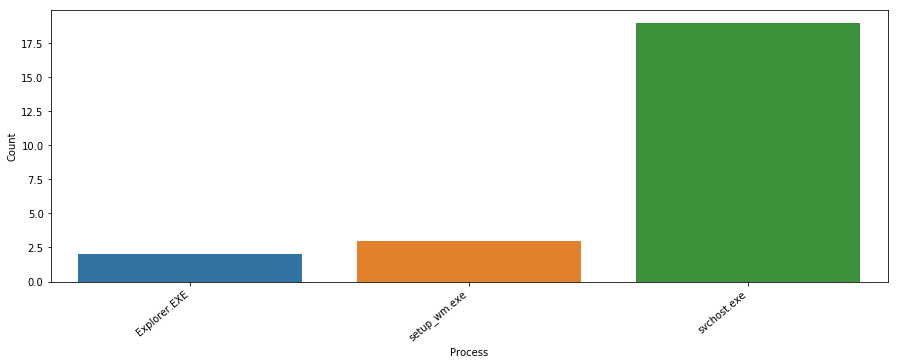

In [10]:
process_target_pair = registry_value_set[(registry_value_set.Process != "integrator.exe") &
                                         (registry_value_set.Process != "msiexec.exe")].groupby(
    ["Process"]
).count()['EventID'].reset_index()

process_target_pair = process_target_pair.rename(columns={"EventID" : "Count"})

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="Process", y="Count", data=process_target_pair, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

This looks much better! We know have a distribution of which processes are active at modifying the registry and which are not. Let's see what keys are changed the most.


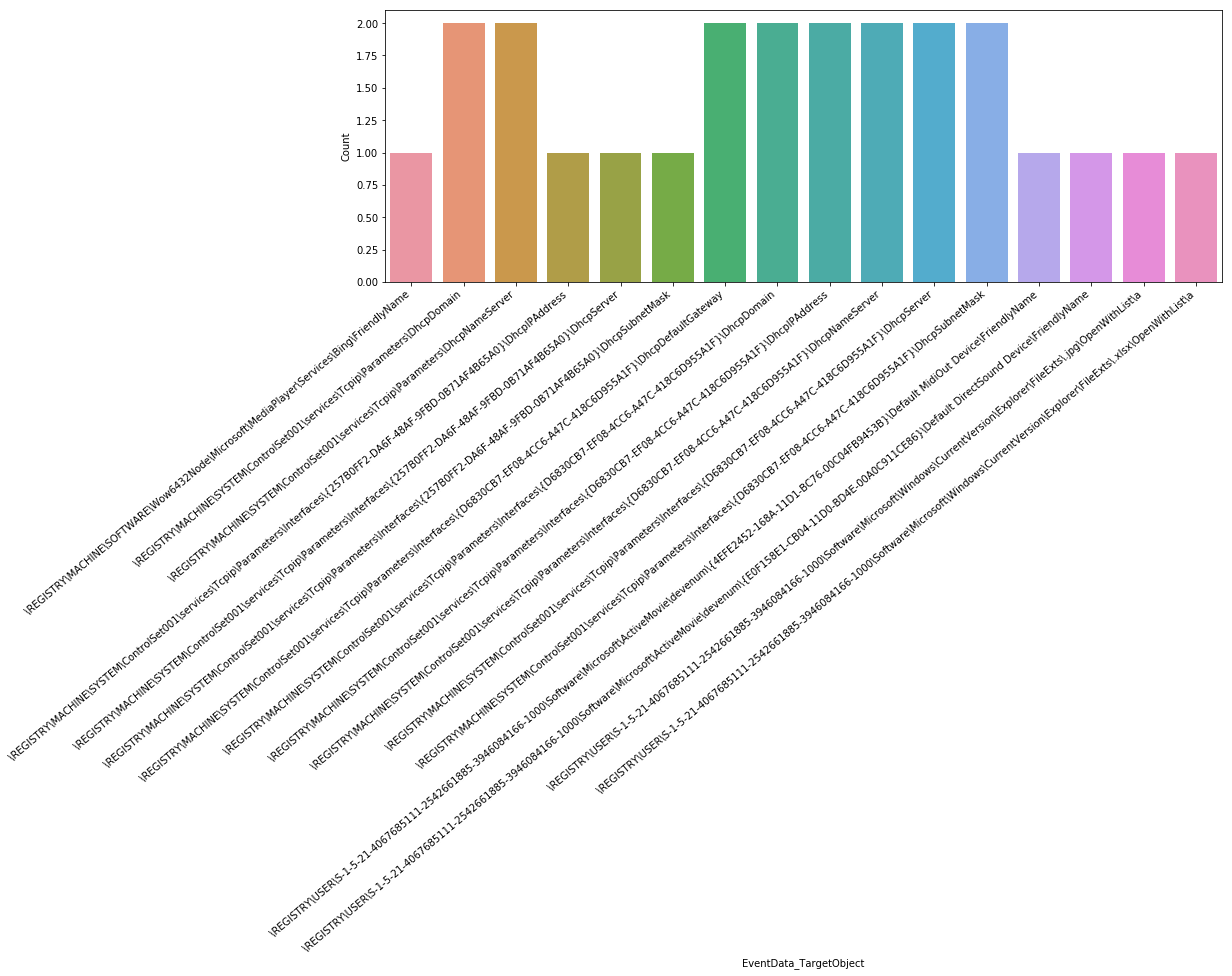

In [11]:
most_frequent_key_changed = registry_value_set[(registry_value_set.Process != "integrator.exe") &
                                               (registry_value_set.Process != "msiexec.exe")].groupby(
    ["EventData_TargetObject"]
).count()['EventID'].reset_index()

most_frequent_key_changed = most_frequent_key_changed.rename(columns={"EventID" : "Count"})

# Graph gets crazy, lets plot a sample

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="EventData_TargetObject", y="Count", data=most_frequent_key_changed, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

It looks like sysmon stores the values including the [registry hives](https://msdn.microsoft.com/en-us/library/windows/desktop/ms724877.aspx). This is not relevant as it will change on a per computer basis, for example the SID (S-1-XXX-XXX) is a unique identifier for a user, we dont want to train our algorithm to only work on one computer). These will always be the first two segment of the key (first two values seperated by slashes). Let's remove those for this to get a better distribution.


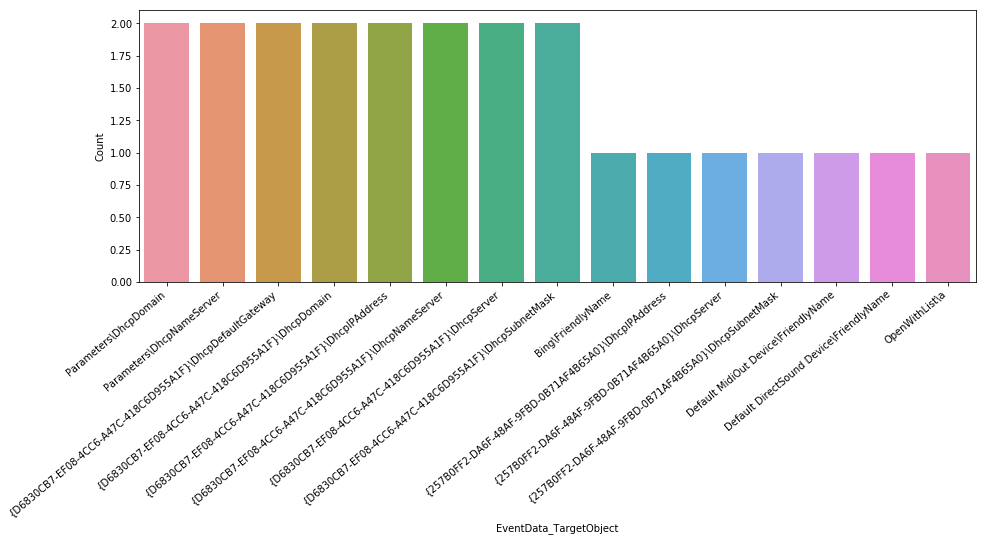

In [12]:
# Remove the hive
most_frequent_key_changed_no_hive = registry_value_set[(registry_value_set.Process != "integrator.exe") &
                                                       (registry_value_set.Process != "msiexec.exe")].groupby(
    ["EventData_TargetObject"]
).count()['EventID'].reset_index()

most_frequent_key_changed_no_hive['EventData_TargetObject'] = most_frequent_key_changed_no_hive[
    'EventData_TargetObject'
].apply(lambda x: '\\'.join(x.split("\\")[-2:]))


most_frequent_key_changed_no_hive = most_frequent_key_changed_no_hive.rename(columns={"EventID" : "Count"})

most_frequent_key_changed_no_hive.sort_values(by="Count", inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="EventData_TargetObject", y="Count", data=most_frequent_key_changed_no_hive, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

__TODO:__ Wrap up registry

Looks like we are slowly getting a better idea of a way to group together normal activity across different processes with regards to the registry key set value event type.

### Process Creation EDA

The next data type I want to take a look at is the ProcessCreation data type. Sysmon will log each process started on the machine, it's location, and the command line arguments started with it. All three of these are important as we can potentially identify previously [unseen process names](https://www.hybrid-analysis.com/sample/00fba93cee17df9d76475c4a07ecbc4663917990d5175284f4ec9fd5e9de9314?environmentId=100), or processes running from [unusual locations](https://forums.malwarebytes.com/topic/164282-fake-svchostexe-cwindowstemp-100-cpu/). We can also identify processes using built-in windows utilities such as powershell to [run malicious code](https://www.hybrid-analysis.com/sample/2e772135303c635d12bb46a7bba18d0898df0ec13cd556b04254e14f148b7919?environmentId=100#sample-analysis)

In [13]:
process_creation = baseline[baseline['EventID'] == "1"]
# Drop all rows that are empty for all events. This happens because of how spares our features are 
process_creation = process_creation.dropna(axis=1)
process_creation.columns


# Let's only grab the data specific to this event type from the dataframe this time.

process_creation = process_creation[[col for col in process_creation.columns if "EventData" in col]]
process_creation.head()

,EventData_CommandLine,EventData_CurrentDirectory,EventData_Hashes,EventData_Image,EventData_IntegrityLevel,EventData_LogonGuid,EventData_LogonId,EventData_ParentCommandLine,EventData_ParentImage,EventData_ParentProcessGuid,EventData_ParentProcessId,EventData_ProcessGuid,EventData_ProcessId,EventData_TerminalSessionId,EventData_User,EventData_UtcTime
0,wevtutil cl Microsoft-Windows-Sysmon/Operational,C:\Users\yampelo\,SHA256=0DD7D2A9E56AE356591C1792EFB68A90FD76A77...,C:\Windows\System32\wevtutil.exe,High,{1a8edbb7-f4d1-5a29-0000-002007b40100},0x000000000001b407,"""C:\Windows\system32\cmd.exe""",C:\Windows\System32\cmd.exe,{1a8edbb7-b4ad-5a2a-0000-0010a4f16500},4448,{1a8edbb7-b55f-5a2a-0000-001038447200},1740,1,WIN-Q9JPOBVS95D\yampelo,2017-12-08 15:53:03.647
1,taskhost.exe $(Arg0),C:\Windows\system32\,SHA256=A01BCD7E884E407C82DEB84D5B31F517F32A4FA...,C:\Windows\System32\taskhost.exe,System,{1a8edbb7-f4d0-5a29-0000-0020e5030000},0x00000000000003e5,C:\Windows\system32\services.exe,C:\Windows\System32\services.exe,{1a8edbb7-f4ce-5a29-0000-001082d10000},508,{1a8edbb7-c748-5a2a-0000-00109f647200},3896,0,NT AUTHORITY\LOCAL SERVICE,2017-12-08 17:09:28.223
2,"cmd /c """"C:\Program Files\VMware\VMware Tools\...",C:\Windows\system32\,SHA256=8651E663D5EFFB9022046AB46452A102D1F31F5...,C:\Windows\System32\cmd.exe,System,{1a8edbb7-f4ce-5a29-0000-0020e7030000},0x00000000000003e7,"""C:\Program Files\VMware\VMware Tools\vmtoolsd...",C:\Program Files\VMware\VMware Tools\vmtoolsd.exe,{1a8edbb7-f4d3-5a29-0000-0010d72d0200},1652,{1a8edbb7-c748-5a2a-0000-00108e667200},2272,0,NT AUTHORITY\SYSTEM,2017-12-08 17:09:28.332
3,"""C:\Program Files\VMware\VMware Tools\VMwareRe...",C:\Windows\system32\,SHA256=8F984E55C897C10FBB8FEE218F1A9C1E0D5819B...,C:\Program Files\VMware\VMware Tools\VMwareRes...,System,{1a8edbb7-f4ce-5a29-0000-0020e7030000},0x00000000000003e7,"""C:\Program Files\VMware\VMware Tools\vmtoolsd...",C:\Program Files\VMware\VMware Tools\vmtoolsd.exe,{1a8edbb7-f4d3-5a29-0000-0010d72d0200},1652,{1a8edbb7-c748-5a2a-0000-0010e6667200},4028,1,NT AUTHORITY\SYSTEM,2017-12-08 17:09:28.348
4,C:\Windows\system32\ipconfig /renew,C:\Windows\system32\,SHA256=34DF739526C114BB89470B3B650946CBF7335CB...,C:\Windows\System32\ipconfig.exe,System,{1a8edbb7-f4ce-5a29-0000-0020e7030000},0x00000000000003e7,"cmd /c """"C:\Program Files\VMware\VMware Tools\...",C:\Windows\System32\cmd.exe,{1a8edbb7-c748-5a2a-0000-00108e667200},2272,{1a8edbb7-c748-5a2a-0000-001002717200},4884,0,NT AUTHORITY\SYSTEM,2017-12-08 17:09:28.504


This data looks amazing for the kind of analysis mentioned in the previous block. It looks like we have the following data in each row.

1. Process name + path (`EventData_Image`)
2. Directory launched from (`EventData_CurrentDirectory`)
3. Command line used (`EventData_CommandLine`)
4. User who ran it (`EventData_User`)
5. Process who launched it (`EventData_ParentImage`)

Let's try seeing which processes usually launch which processes, and which processes run from what directories usually.

In [14]:
parent_child = process_creation.groupby(["EventData_Image", "EventData_ParentImage"])
parent_child.size().sort_values(ascending=False).to_frame().head()

,,0
EventData_Image,EventData_ParentImage,
C:\Users\yampelo\AppData\Roaming\Spotify\Spotify.exe,C:\Users\yampelo\AppData\Roaming\Spotify\Spotify.exe,3
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe,C:\Windows\explorer.exe,2
C:\Windows\System32\wevtutil.exe,C:\Windows\System32\cmd.exe,1
C:\Windows\System32\taskhost.exe,C:\Windows\System32\services.exe,1
C:\Windows\System32\notepad.exe,C:\Windows\explorer.exe,1


In [15]:
processes_by_path = pd.DataFrame(process_creation['EventData_Image'])
processes_by_path['path'] = processes_by_path['EventData_Image'].apply(
    lambda x: '\\'.join(x.split("\\")[:-1])
)
processes_by_path['process'] = processes_by_path['EventData_Image'].apply(
    lambda x: x.split("\\")[-1]
)
processes_by_path.drop("EventData_Image", inplace=True, axis=1)

processes_by_path.groupby(["path", "process"]).size().to_frame()

0
path                                             process                   
C:\Program Files (x86)\Google\Chrome\Application chrome.exe               2
C:\Program Files (x86)\Microsoft Office\Office15 EXCEL.EXE                1
                                                 POWERPNT.EXE             1
                                                 WINWORD.EXE              1
C:\Program Files (x86)\Windows Media Player      setup_wm.exe             1
                                                 wmplayer.exe             1
C:\Program Files\VMware\VMware Tools             VMwareResolutionSet.exe  1
C:\Users\yampelo\AppData\Roaming\Spotify         Spotify.exe              4
C:\Windows\System32                              cmd.exe                  1
                                                 ipconfig.exe             1
                                                 notepad.exe              1
                                                 taskhost.exe             1
                                                 wevtutil.exe             1

We can also generally see where processes run from.

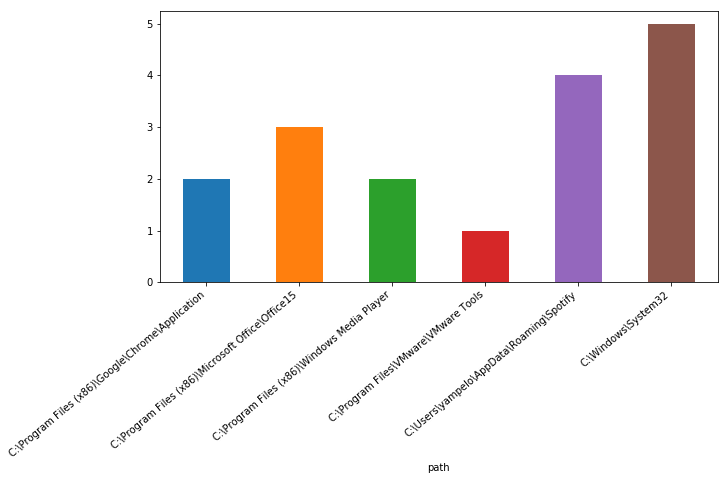

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
processes_by_path.groupby(["path"]).size().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show()

We can actually get a more generalized idea of where things execute from by looking at execution counts across all sysmon events that has a `EventData_Image` column.

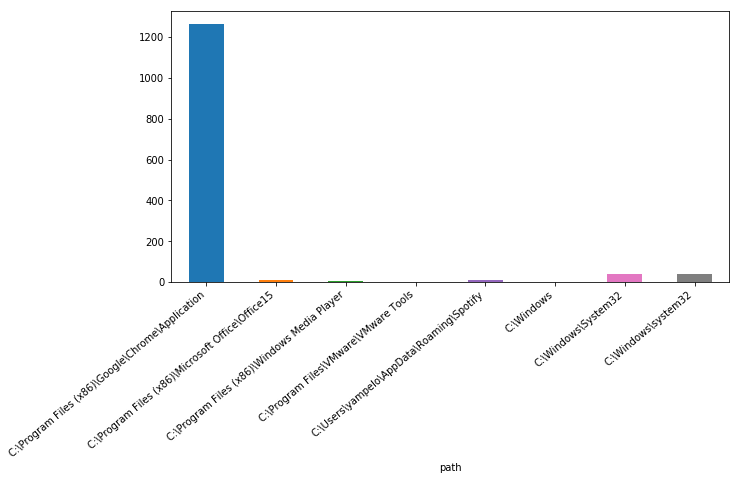

In [17]:
all_events_processes_by_path = pd.DataFrame()
all_events_processes_by_path['path'] = baseline['EventData_Image'].apply(
    lambda x: '\\'.join(x.split("\\")[:-1])
)
all_events_processes_by_path['process'] = baseline['EventData_Image'].apply(
    lambda x: x.split("\\")[-1]
)

fig, ax = plt.subplots(figsize=(10,5))
all_events_processes_by_path.groupby(["path"]).size().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show()

I also think it is of interest to view the command line arguments invoked by each process, let's see if there's any least frequency based analysis we can do on this column in our dataset.

In [18]:
process_creation.groupby("EventData_CommandLine").size().to_frame()

,0
EventData_CommandLine,
"""C:\Program Files (x86)\Google\Chrome\Application\chrome.exe""",2
"""C:\Program Files (x86)\Microsoft Office\Office15\EXCEL.EXE""",1
"""C:\Program Files (x86)\Microsoft Office\Office15\POWERPNT.EXE""",1
"""C:\Program Files (x86)\Microsoft Office\Office15\WINWORD.EXE"" /n ""C:\Users\yampelo\Desktop\This is my favorite document I hate data science.docx"" /o ""u""",1
"""C:\Program Files (x86)\Windows Media Player\setup_wm.exe"" /RunOnce:""C:\Program Files (x86)\Windows Media Player\wmplayer.exe"" /prefetch:1",1
"""C:\Program Files (x86)\Windows Media Player\wmplayer.exe"" /prefetch:1",1
"""C:\Program Files\VMware\VMware Tools\VMwareResolutionSet.exe"" 0 1 , 0 0 1920 1080 0",1
"""C:\Users\yampelo\AppData\Roaming\Spotify\Spotify.exe""",1
"""C:\Users\yampelo\AppData\Roaming\Spotify\Spotify.exe"" --type=gpu-process --disable-d3d11 --lang=en-US --log-file=""C:\Users\yampelo\AppData\Roaming\Spotify\debug.log"" --log-severity=disable --product-version=Spotify/1.0.69.336 --disable-direct-composition --supports-dual-gpus=false --gpu-driver-bug-workarounds=9,12,13,22,23,24,27,49,84 --disable-gl-extensions=""GL_KHR_blend_equation_advanced GL_KHR_blend_equation_advanced_coherent"" --gpu-vendor-id=0x15ad --gpu-device-id=0x0405 --gpu-driver-vendor=""VMware, Inc."" --gpu-driver-version=8.15.1.51 --gpu-driver-date=3-16-2017 --lang=en-US --log-file=""C:\Users\yampelo\AppData\Roaming\Spotify\debug.log"" --log-severity=disable --product-version=Spotify/1.0.69.336 --service-request-channel-token=E1A5FFCC775170C860547ED0E8E395CB --mojo-platform-channel-handle=1208 --ignored="" --type=renderer "" /prefetch:2",1


It looks like there's no real significance in the count of each command line, (except that this person does not like datascience as seen by his word documents) since the most launched process is simply at 2 because chrome was ran twice.

## Network Connection EDA

The last one I want to explore is the network connection data type. Let's see what kind of data we can pull out of that. Let's see which processes talk to the internet the most.

In [19]:
network_connection = baseline[baseline['EventID'] == "3"]
network_connection = network_connection.dropna(axis=1)

network_connection.groupby("EventData_Image").size().to_frame()

,0
EventData_Image,
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe,1245
C:\Program Files (x86)\Microsoft Office\Office15\EXCEL.EXE,3
C:\Program Files (x86)\Microsoft Office\Office15\POWERPNT.EXE,2
C:\Program Files (x86)\Microsoft Office\Office15\WINWORD.EXE,1
C:\Program Files (x86)\Windows Media Player\setup_wm.exe,2
C:\Windows\System32\svchost.exe,5


Now let's see to which ports they talk to, I don't think the IPs they talk to are relevant, this is because an IP is something extremly dynamic.

In [20]:
network_connection.groupby("EventData_DestinationPort").size().sort_values(ascending=False).to_frame()

,0
EventData_DestinationPort,
443,933
80,321
67,3
53,1


Now this is interesting, it looks we usually talk over HTTP/S (443, and 80). This could prove useful later when we wish to classify as malware usually talks over very high ports.

--- 

I think our baseline data is good enough. This represents the activity of a non power-user on a machine. They open some documents, create some files, and browse the internet. Let's create our malicious data now.

## Creating a Malicious dataset

We have our labeled good data, now we need to create our malicious dataset. To do this I have created a set of python scripts (each one covered later on in the tutorial) that imitiate real world malware. These are all available under the `bin/malware/src` folder of the repository.

Each malware extends a base class I created called `MalwareBase` which provides some functions to . We will be doing the following workflow to generate our malicious data:

1. Compile a python malware using [pyinstaller](http://www.pyinstaller.org/)
2. Move the executable over to the VM using the `vmrun` command.
3. Run the executable and copy over the Sysmon log. 
4. Revert to our clean snapshot.

I have placed precompiled versions of all psuedo-malicious binaries used to generate the malicious dataset under the `bin/malware/dist` folder in the github repository.

* If you wish to compile the binaries yourself, do so on a windows machine using `pyinstaller -p .. <.py_to_compile>`. The `-p ..` is required since I used the `malware` class which sits in the parent directory of all the actually "malicious" scripts and this forces `pyinstaller` to compile it as well.

### Automating the Training Data Generation Pipeline

Since I wish to generate a sufficiently large dataset for my labeled malicious data, I want to be able to do this as quickly possible, and make it as dynamic as possible so in the future if I wish to create labeled data to model new malicious behavior I do not have to do it manually. The process mentioned above is tedious and time consuming, instead, I createed a script (available under `bin/utils`) which automates the 4 step process mentioned above.

The script makes use of the a modified [vmrun](https://github.com/binjo/vmrun-python/blob/master/vmrun.py) wrapper for the `vmrun` command we used earlier. I have included the modified version under `bin/utils/lib/vmrun.py`.

It is available under as `bin/utils/vm_copy_run_reset.py` in the github repository.

The script can be used using the following parameters:

```bash
usage: vm_copy_run_reset.py [-h] [--path PATH] [--log_dir LOG_DIR]
                            [--times TIMES] [--dest_path DEST_PATH]
                            (--normal NORMAL | --randomize)

optional arguments:
  -h, --help            show this help message and exit
  --path PATH           The folder containing the files to copy over. This
                        script executes the first .exe it finds in this folder
                        on the VM
  --log_dir LOG_DIR     The directory to put the sysmon logs copied over
                        after.the log files will be placed in <log_dir>/<time>/
  --times TIMES         Number of times to run the executable (default 1)
  --dest_path DEST_PATH
  --normal NORMAL       Run the executable with the provided name
  --randomize           Run the executable --times <n> times with a randomly
                        generated name each timeand copy over the sysmon log
                        after each run
```

The below video shows an example of invoking the script with the `regkey_persistence.exe` binary and a randomized file name. The following parameters were used:

```bash
python vm_copy_run_reset.py --path ../malware/dist/regkey_persistence
                            --log_dir ../../data/malicious_train/regkey_persist/
                            --times 25
                            --dest_path C:\\users\\admin\\appdata\\local
                            --randomize
```


<video src="static/vid/automated_log_collection.webm" width=1000 height="50%" controls>
</video>

And we now have 25 sysmon logs representing 25 different executions of this malware.

```bash
| => ls -laR
total 0
drwxr-xr-x  3 yampelo  staff   96 Dec  9 18:34 .
drwxr-xr-x  3 yampelo  staff   96 Dec  9 17:56 ..
drwxr-xr-x  7 yampelo  staff  224 Dec  9 18:36 2017_12_09_23_34_21

./2017_12_09_23_34_21:
total 10920
drwxr-xr-x  7 yampelo  staff      224 Dec  9 18:36 .
drwxr-xr-x  3 yampelo  staff       96 Dec  9 18:34 ..
-rwx------  1 yampelo  staff  1118208 Dec  9 18:34 sysmon_log_1
-rwx------  1 yampelo  staff  1118208 Dec  9 18:34 sysmon_log_2
-rwx------  1 yampelo  staff  1118208 Dec  9 18:35 sysmon_log_3
-rwx------  1 yampelo  staff  1118208 Dec  9 18:35 sysmon_log_4
-rwx------  1 yampelo  staff  1118208 Dec  9 18:36 sysmon_log_5
...
```

We can now write a simple function that takes in our folder and returns a list of all of the dataframes for that trial.

In [21]:
import os
def get_trial_dataframes(path):
    """Return an array of dataframes
    
    :param path: The path to the trial.
    """
    logs = []
    for log in os.listdir(path):
        
        logs.append(sysmon_evtx_to_dataframe(path + "/" + log))
        
    return logs

In [22]:
reg_key_persist = get_trial_dataframes("data/malicious_train/regkey_persist/2017_12_10_01_57_15")

reg_key_persist[0].head(1)

,Correlation,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_CommandLine,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,EventData_DestinationIsIpv6,EventData_DestinationPort,...,Execution,Execution_ProcessID,Execution_ThreadID,Provider,Provider_Guid,Provider_Name,Security,Security_UserID,TimeCreated,TimeCreated_SystemTime
0,None,,,wevtutil cl Microsoft-Windows-Sysmon/Operational,NaN,C:\Users\admin\,NaN,NaN,NaN,NaN,...,None,1572,2064,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-09 22:42:30.087566


Let's create a Data frame to store our malicious data:

In [23]:
malicious = pd.DataFrame()

## Writing our Malware

Let's actually find some malicious activity to mimick, run it through our automated data collection script, and explore the generated logs!

### Registry - CurrentVersion\Run Persistence

The most popular method for malware to maintain persistence is through the [CurrentVersion\\Run](https://msdn.microsoft.com/en-us/library/windows/desktop/aa376977(v=vs.85).aspx) keys. The contents of this key are executed each time the user logs in. Let's used our `Malware` class to create malware that mimicks this activity. Below are actual malware samples that use this technique:

1. [TROJANDROPPER.WIN32.RANDREW.A.BIT](https://www.hybrid-analysis.com/sample/4f6e2423aabc8f46be5d33a621a3f906a516a626de76d494acd0b52d705a6370?environmentId=100#sample-analysis)
2. [Win32.Trojan.WisdomEyes.16070401.9500.9994](https://www.hybrid-analysis.com/sample/3a84a91e84d953fbb7811f85ab39aae351f1e8f88f64f74cf10a1e5a44bf049f?environmentId=100#sample-analysis)

To do this, we used our `create_registry_key()` function with the following parameters:

```python
self.create_registry_key(
    key=self.random_string(), # A random alphanumeric string
    value=sys.executable, # The name of the program on the VM
    path=r'Software\Microsoft\Windows\CurrentVersion\Run',
    hive=winreg.HKEY_CURRENT_USER
)
```

This is available under `bin/malware/generic/reg_key_persistence.py` and the executable under `/bin/malware/dist/reg_key_persistence/reg_key_persistence.exe`

The sysmon logs from running this 25 times with randomized executable names are available under `data/malicious_train/regkey_persist/2017_12_10_01_57_15`

These logs were generated using the same parameters show [here](#Automating-the-Training-Data-Generation-Pipeline)

Let's see what this looks like. We will key in on the `Registry (Create Key)` and `Registry (Edit Value)` 

In [24]:
"""
The below are the EventIDs we are interested in.
"12":"RegistryEvent (Object create and delete)",
"13":"RegistryEvent (Value Set)",
"""
reg_key_persist = get_trial_dataframes("data/malicious_train/regkey_persist/2017_12_10_01_57_15")

In [25]:
combined = pd.DataFrame()
for frame in reg_key_persist:
    events_of_interest = frame[(frame.EventID == "12") |(frame.EventID == "13")]
    combined = combined.append(events_of_interest)

combined.groupby("EventData_Image").size().to_frame()

,0
EventData_Image,
C:\Windows\System32\svchost.exe,1037
C:\Windows\system32\msiexec.exe,26
C:\Windows\system32\svchost.exe,594
C:\Windows\syswow64\MsiExec.exe,2
C:\users\admin\appdata\local\0jPI9Kb5TGj3cmGLEYdTP6.exe,1
C:\users\admin\appdata\local\ADHumuCMVw1Lesid.exe,1
C:\users\admin\appdata\local\CXIodS2Vuu7sgg0DOpb.exe,1
C:\users\admin\appdata\local\EUSRyAUGswEIykFKcrOv.exe,1
C:\users\admin\appdata\local\GIjrrE7gh5EPeZJ088A.exe,1


Looks like our tool worked! our malicious processes are right there. Let's see what sysmon picked up on them doing. We can narrow down on just events in appdata local using the following code.

The following columns represent the following data:

1. `EventData_Image` $\rightarrow$ The process setting the registry key 
2. `EventData_TargetObject` $\rightarrow$ The registry key being set (i extract the relevant part as reg_key)
3. `EventData_Details` $\rightarrow$ The contents of the registry key 

In [26]:
# Split out the path
combined['path'] = combined['EventData_Image'].apply(
    lambda x: '\\'.join(x.split("\\")[:-1])
)

combined['reg_key'] = combined['EventData_TargetObject'].apply(
    lambda x: '\\'.join(x.split("\\")[-4:])
)

# Narrow down on just the path
malware = combined[combined.path == "C:\\users\\admin\\appdata\\local"]

malware[["EventData_Image", "reg_key", "EventData_Details"]]

,EventData_Image,reg_key,EventData_Details
94,C:\users\admin\appdata\local\OX2Jv0lR3bLurcA9f...,Windows\CurrentVersion\Run\QaMdBrpv,C:\users\admin\appdata\local\OX2Jv0lR3bLurcA9f...
107,C:\users\admin\appdata\local\hQOGjGr9bgEfAS.exe,Windows\CurrentVersion\Run\Q5NgRIXxL0hmsyF36aC08Q,C:\users\admin\appdata\local\hQOGjGr9bgEfAS.exe
99,C:\users\admin\appdata\local\CXIodS2Vuu7sgg0DO...,Windows\CurrentVersion\Run\Hq1pdEJzNF,C:\users\admin\appdata\local\CXIodS2Vuu7sgg0DO...
100,C:\users\admin\appdata\local\0jPI9Kb5TGj3cmGLE...,Windows\CurrentVersion\Run\yAeacJWS2Vso,C:\users\admin\appdata\local\0jPI9Kb5TGj3cmGLE...
104,C:\users\admin\appdata\local\YRP1mMLn3S0.exe,Windows\CurrentVersion\Run\qMvmPjMKiC2H9YC6lh,C:\users\admin\appdata\local\YRP1mMLn3S0.exe
100,C:\users\admin\appdata\local\IkrGhzit3U2nb.exe,Windows\CurrentVersion\Run\9n7llzAtFLLtmnlzFQC...,C:\users\admin\appdata\local\IkrGhzit3U2nb.exe
99,C:\users\admin\appdata\local\TnQ7NyIIGY2pTYr7T...,Windows\CurrentVersion\Run\KRWWvpqh,C:\users\admin\appdata\local\TnQ7NyIIGY2pTYr7T...
94,C:\users\admin\appdata\local\PbvguIYJZ.exe,Windows\CurrentVersion\Run\ztTAvZv9PTCDngkD8,C:\users\admin\appdata\local\PbvguIYJZ.exe
93,C:\users\admin\appdata\local\Rby8xeQ9ErxA54boN...,Windows\CurrentVersion\Run\w1luiF9QJCzdn4XjqR2KX,C:\users\admin\appdata\local\Rby8xeQ9ErxA54boN...
104,C:\users\admin\appdata\local\HPIPDDAIXRJz4.exe,Windows\CurrentVersion\Run\UmvhN5orEBMaxeSor9,C:\users\admin\appdata\local\HPIPDDAIXRJz4.exe


Let's add this to our training data and give it a description

In [27]:
# I grab the events from the original frames before any apply commands since
# I want to be able to just load any sysmon log and classify it through a single function
for frame in reg_key_persist:
    for _, row in frame.iterrows():
        if 'appdata\\local' in str(row.EventData_Details):
            row['label'] = 'malware'
            row['label_desc'] = "persistence via registry key"
            malicious = malicious.append(row)

## Scheduled Tasks - Timed Execution

Another very popular method for malware to execute it self is through scheduled tasks. The windows scheduled task broker can be used to launch an executable every minute, hour, day, or even on boot. All the flags can be seen [here](https://technet.microsoft.com/en-us/library/bb490996.aspx).

Malware will typically use the `onstart` parameter to do cause the malware to run on boot. Here are some examples of malware doing this:

1. [Trojan-Banker.Win32.Delf.ggam](https://www.hybrid-analysis.com/sample/d71fadcc29771da01fd38545a7011e642ec003d03ec789b8cb11a99ef84e85b9?environmentId=100#sample-analysis)
2. [Trojan.MSIL.Zyklon](https://www.hybrid-analysis.com/sample/b5a0202b7c5eec95594754716c38a2d64bacddcfb05bb52928b32cbcc8950f15?environmentId=100#sample-analysis)

Let's recreate this behavior using our `Malware` class. I wrote a function called `create_scheduled_tasks` that creates a scheduled task by invoking the [`schtasks.exe`](https://technet.microsoft.com/en-us/library/bb490996.aspx) executable. 

```python
    self.create_scheduled_task(
        name= self.random_string(), # Randomally named task
        file= sys.executable,       # Executable
        freq_cmd = "onstart",       # Launch on boot
    )
```

This is available under `bin/malware/generic/task_persistence.py` and the compiled executable under `/bin/malware/dist/task_persistence/task_persistence.exe`

The sysmon logs from running this 25 times with randomized executable names are available under `data/malicious_train/task_persist/2017_12_10_02_20_09/`

The logs were generated using the following parameters to `vm_run_copy_reset.py`

```bash
python vm_copy_run_reset.py --path ../malware/dist/task_persistence
                            --log_dir ../../data/malicious_train/task_persist
                            --times 25
                            --dest_path C:\\users\\admin\\appdata\\local
                            --randomize
```


In [28]:
task_persist = get_trial_dataframes("data/malicious_train/task_persist/2017_12_10_02_20_09")

This time we are interested in the `Process Created` Event ID (Event ID 1). This is because we explicitly launch the `schtasks.exe` process with specific arguments in order to create our task.

Let's look for all command lines that include the `schtasks.exe` process that we invoked.

In [29]:
combined = pd.DataFrame()
for frame in task_persist:
    events_of_interest = frame[(frame.EventID == "1")]
    combined = combined.append(events_of_interest)

    
malware = pd.DataFrame()

for _, row in combined.iterrows():
    if "schtasks" in str(row.EventData_CommandLine):
            malware = malware.append(row)

# Prevent pandas from truncating data, this is because our command line arguments can get long.
pd.set_option('display.max_colwidth', -1)

malware.groupby(["EventData_Image", "EventData_CommandLine"]).size().to_frame()

0
EventData_Image                  EventData_CommandLine                                                                                                                                          
C:\Windows\SysWOW64\cmd.exe      C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 2dMGKRtQfX /TR C:\users\admin\appdata\local\SAzALYpAndE.exe"                             1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 4zseLMxsWW1qeIL0H7vayyEg /TR C:\users\admin\appdata\local\06xSX9lIz2WqRkkUEPKQF7jI.exe"  1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 5kmwh5IJw94 /TR C:\users\admin\appdata\local\mXENWW7ugzXb.exe"                           1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 947peTjIMJsLHmyh /TR C:\users\admin\appdata\local\ZCIkdEQ4IxIZR8Os.exe"                  1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 9WRtJHp1pp /TR C:\users\admin\appdata\local\42UcaImHdqe2QG22k.exe"                       1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn CvFVBs8zs0s0FBY7JAPzy2 /TR C:\users\admin\appdata\local\Ryi6a8aTXY.exe"                  1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn ES0oAHxq /TR C:\users\admin\appdata\local\CjzBlcYFaL4RFbj3qD0qMAXt.exe"                  1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn KagYlFHBzLMs2pgcj2Um /TR C:\users\admin\appdata\local\a4aSeptRzAgLiHIzPlgvmqHS.exe"      1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn NW0AMIbcOXiMLHosDm6xNIl /TR C:\users\admin\appdata\local\1OtSC2MDKbfyGSU5zu9Iz3y.exe"    1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn XH7TlISZ58Db1KJNyFA /TR C:\users\admin\appdata\local\cA5mvBjs8NJh.exe"                   1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn YQTM6MnfTgO /TR C:\users\admin\appdata\local\OXVUKQBE42i.exe"                            1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn fVeCn4Xsf /TR C:\users\admin\appdata\local\AWAeJ35zyQQbO.exe"                            1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn hpxqDkWWaQ0t5 /TR C:\users\admin\appdata\local\Cxy6EnrAkJCic3.exe"                       1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn jo4Lc8mVUrHaZU /TR C:\users\admin\appdata\local\tS2xJVFKT8FF5xuJuAon.exe"                1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn lH61P1l9ZrsEAFnElIZ9z /TR C:\users\admin\appdata\local\IxGS2STpPghAjRuHS.exe"            1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn rbP1yOVxTzj /TR C:\users\admin\appdata\local\1ljEpJ6UcP7yu1jmHSLuwt.exe"                 1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn uSZ9NjdMnr8xl5EKJ0Hp /TR C:\users\admin\appdata\local\2sAfssoP5.exe"                     1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn vQhkN56moF /TR C:\users\admin\appdata\local\UcD44EVKYSmA4d.exe"                          1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn vRr2KLFh8G6qH /TR C:\users\admin\appdata\local\y60iQxa5q5eU8zmJ.exe"                     1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn w7dRaXnmgcHoTo76AHtN9 /TR C:\users\a

Let's add these events to our labeled malicious data and give it a description.

In [30]:
for frame in task_persist:
    for _, row in frame.iterrows():
        if 'schtasks' in str(row.EventData_CommandLine):
            row['label'] = 'malware'
            row['label_desc'] = "scheduled task timed execution"
            malicious = malicious.append(row)

In [31]:
malicious.sample(5)

,Correlation,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_CommandLine,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,EventData_DestinationIsIpv6,EventData_DestinationPort,...,Provider,Provider_Guid,Provider_Name,Security,Security_UserID,TimeCreated,TimeCreated_SystemTime,label,label_desc,EventData_PipeName
104,None,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:00:13.461870,malware,persistence via registry key,NaN
93,None,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 01:59:21.038202,malware,persistence via registry key,NaN
107,None,,,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn lH61P1l9ZrsEAFnElIZ9z /TR C:\users\admin\appdata\local\IxGS2STpPghAjRuHS.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:37:56.650150,malware,scheduled task timed execution,NaN
99,None,,,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn vQhkN56moF /TR C:\users\admin\appdata\local\UcD44EVKYSmA4d.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:23:06.970858,malware,scheduled task timed execution,NaN
85,None,,,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn y0kAMRNt0l7i /TR C:\users\admin\appdata\local\xio0Ir5SmOoYitAO.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:20:30.112007,malware,scheduled task timed execution,NaN


## RansomWare - File Create

The next malicious thing we will emulate is a complete malware family, ransomware. This malware family has made headlines when [wannacry](https://en.wikipedia.org/wiki/WannaCry_ransomware_attack), [cryptolocker](https://en.wikipedia.org/wiki/CryptoLocker) and especially when it was used as a cyber-weapon against ukraine in 2017 through [petya](https://en.wikipedia.org/wiki/2017_cyberattacks_on_Ukraine).

Ransomware will take all of the users file on the system, encrypt them, and change the file extension to of the files to let the user know the files are encrypted, for example [locky](https://en.wikipedia.org/wiki/Locky) used the `.locky` extension. 

Let's write a simple python script that starts in the users home folder and recursivly creates a copy of every file it sees and adds the extension `.keycrypted`. 

```python
def encrypt_all(path):
    for file in os.listdir(path):
        if os.path.isdir(file):
            encrypt_all(file)
        else:
            with open(file + EXTENSION, "w") as f:
                f.write(" ")
                f.close()
```

We can then call `encrypt_all(os.getcwd())` to "encrypt" all subdirectories from where our 

The compiled executable is available under `bin/malware/dist/ransomware/ransomware.exe` and the source code is available under `/bin/malware/generic/ransomware.py` in the Github repository.


For this one I will only generate two training sets of data, as we will get back very large files from the amount of events.

The following parameters were used to generate this training data:

```bash
python vm_copy_run_reset.py --path ../malware/dist/ransomware
                            --log_dir ../../data/malicious_train/ransomware
                            --times 2
                            --dest_path C:\\users\\admin
                            --randomize
```

The sysmon logs from running this 2 times with randomized executable names are available under `data/malicious_train/ransomware/2017_12_10_21_22_27`

In [32]:
ransomware = get_trial_dataframes("data/malicious_train/ransomware/2017_12_10_21_22_27")

This time we are interested in file write events. This is EventID 11.

Since we modified a lot of files. I belive that this time we will get a considerably larger amount of events in our dataframe, let's see how many rows we have.

In [33]:
combined = pd.DataFrame()
for frame in ransomware:
    events_of_interest = frame[(frame.EventID == "11")]
    combined = combined.append(events_of_interest)
    
print(f"Rows: {combined.shape[0]}")

Rows: 32724


32 thousand events from 30 seconds of execution! Let's see which processes wrote the most files.

In [34]:
combined.groupby("EventData_Image").size().sort_values(ascending=False).to_frame()

,0
EventData_Image,
C:\users\admin\w6MmIaVkBiK.exe,16315
C:\users\admin\qJi85X21i3CFd8jDg4jRf.exe,16315
C:\Program Files\VMware\VMware Tools\vmtoolsd.exe,76
C:\Windows\system32\services.exe,18


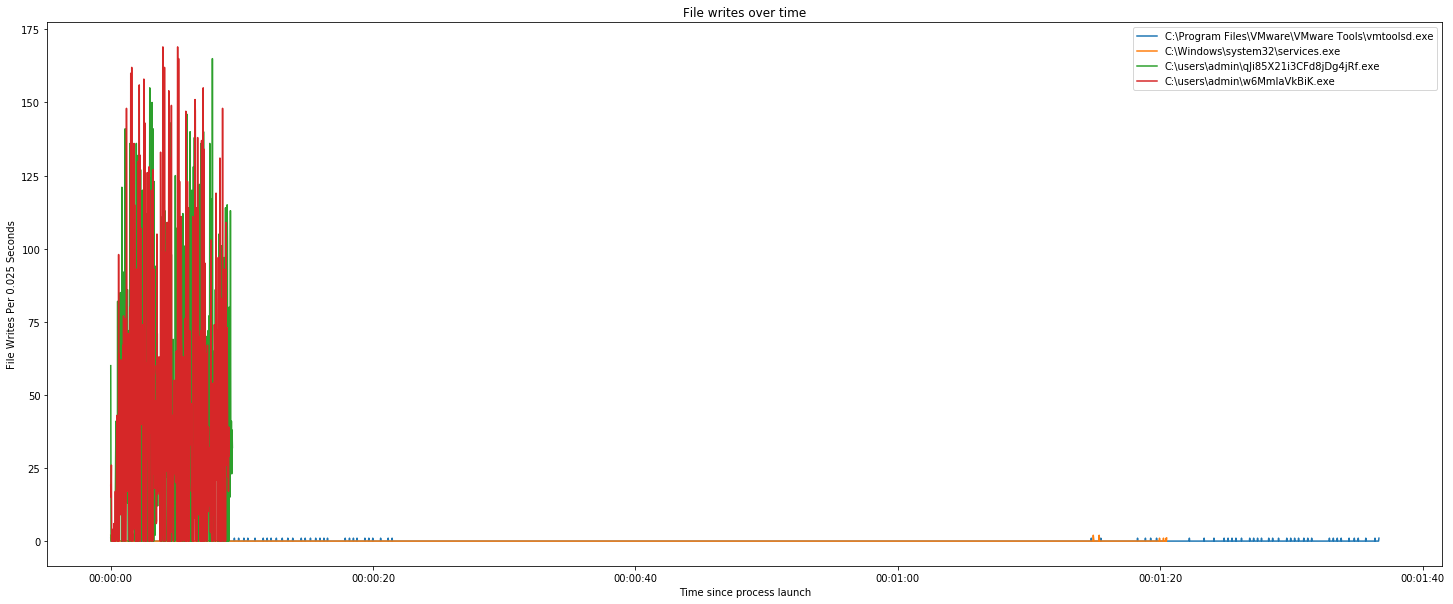

In [35]:
import random
def random_color():
    return ("#%06x" % random.randint(0, 0xFFFFFF))

combined['TimeCreated_SystemTime'] = pd.to_datetime(combined["TimeCreated_SystemTime"])


fig, ax = plt.subplots(figsize=(25,10))

for name, grp in combined.groupby("EventData_Image"):
    
    # We want to standerdize the events across different time segments
    # lets convert the times to be offsets of the first event
    # and lets make the first event 0
        
    data = grp.copy() 
    
    first = grp[['TimeCreated_SystemTime']].sort_values(
        by="TimeCreated_SystemTime", ascending=True
    ).iloc[0]['TimeCreated_SystemTime']
    
    data['TimeCreated_SystemTime'] = data['TimeCreated_SystemTime'] - first

    data.set_index("TimeCreated_SystemTime", inplace=True)
    data = data.resample("0.025S").count()[['EventID']]
    data = data.rename({"EventID" : name}, axis=1)
    data.plot(ax=ax)
    

ax.set_title("File writes over time")   
ax.set_ylabel("File Writes Per 0.025 Seconds")
ax.set_xlabel("Time since process launch")
plt.show()

Our ransomware "encryption" events stand out pretty clearily. Let's try doing the same for our baseline data

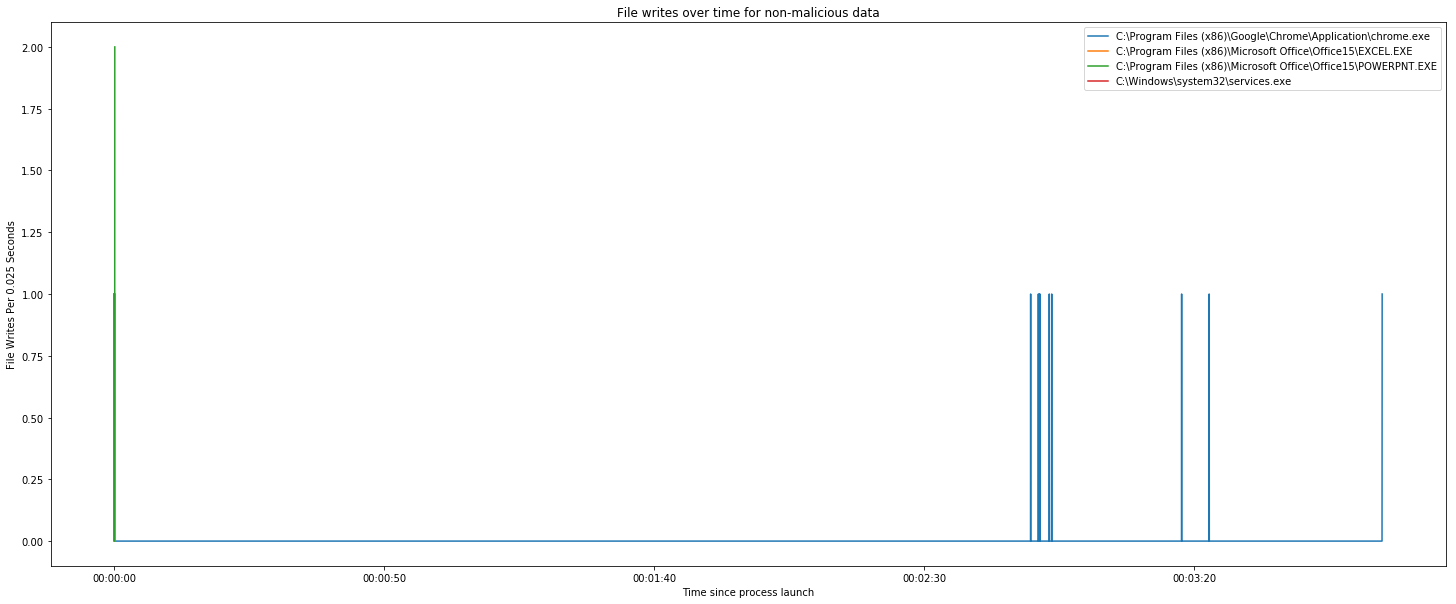

In [36]:
good_filewrites = baseline[baseline.EventID == "11"].copy()

good_filewrites['TimeCreated_SystemTime'] = pd.to_datetime(good_filewrites["TimeCreated_SystemTime"])


fig, ax = plt.subplots(figsize=(25,10))

for name, grp in good_filewrites.groupby("EventData_Image"):
    
    # We want to standerdize the events across different time segments
    # lets convert the times to be offsets of the first event
    # and lets make the first event 0
        
    data = grp.copy() 
    
    first = grp[['TimeCreated_SystemTime']].sort_values(
        by="TimeCreated_SystemTime", ascending=True
    ).iloc[0]['TimeCreated_SystemTime']
    
    data['TimeCreated_SystemTime'] = data['TimeCreated_SystemTime'] - first

    data.set_index("TimeCreated_SystemTime", inplace=True)
    data = data.resample("0.025S").count()[['EventID']]
    data = data.rename({"EventID" : name}, axis=1)
    data.plot(ax=ax)
    

ax.set_title("File writes over time for non-malicious data")   
ax.set_ylabel("File Writes Per 0.025 Seconds")
ax.set_xlabel("Time since process launch")
plt.show()

Finally, let's add our ransomware file write events to our malicious dataset.

In [37]:
for frame in ransomware:
    frame = frame[frame.EventData_TargetFilename.notnull()]
    rows = frame[frame.EventData_TargetFilename.str.contains("keycrypted")].copy()
    rows['label'] = 'malware'
    rows['label_desc'] = "ransomware file writes"
    malicious.append(rows)

In [38]:
malicious.sample(5)

,Correlation,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_CommandLine,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,EventData_DestinationIsIpv6,EventData_DestinationPort,...,Provider,Provider_Guid,Provider_Name,Security,Security_UserID,TimeCreated,TimeCreated_SystemTime,label,label_desc,EventData_PipeName
97,None,,,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn vRr2KLFh8G6qH /TR C:\users\admin\appdata\local\y60iQxa5q5eU8zmJ.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:23:59.684958,malware,scheduled task timed execution,NaN
85,None,,,schtasks.exe /create /sc onstart /tn w7dRaXnmgcHoTo76AHtN9 /TR C:\users\admin\appdata\local\6tzFbjRO74b42ew.exe,NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:32:43.666763,malware,scheduled task timed execution,NaN
97,None,,,schtasks.exe /create /sc onstart /tn XH7TlISZ58Db1KJNyFA /TR C:\users\admin\appdata\local\cA5mvBjs8NJh.exe,NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:37:04.851274,malware,scheduled task timed execution,NaN
98,None,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:01:06.537449,malware,persistence via registry key,NaN
101,None,,,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn 4zseLMxsWW1qeIL0H7vayyEg /TR C:\users\admin\appdata\local\06xSX9lIz2WqRkkUEPKQF7jI.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:24:52.754566,malware,scheduled task timed execution,NaN


# Detecting Malicious Activity

Now that we have labeled datasets for both legit and malicious activity, we can now attempt to create models that will be able to detect the activity we created training sets for.

For the purpose of this tutorial, I will create three different models, one for each of the types of malware we created training data for. We only looked at one EventID for each of the three above malware techniques we mimicked, this means that we can train models only on the fields of those EventIDs, and as such we will have less features to extract and most likely better performance. We will be training the following models:

1. Malicious Registry Key Creation
2. Malicious Scheduled Task
3. Detection of abnormal file creation events for ransomware detection

First let's give our baseline the good class label:

In [170]:
# Label as good 
baseline['label'] = "good"


## Registry Key Creation

Let's start with the startup registry key. Let's grab the events from both the malicious and good datasets and join them together

In [187]:
baseline_reg = baseline[(baseline.EventID == "12") | (baseline.EventID == "13")]
malicious_reg = malicious[(malicious.EventID == "12") | (malicious.EventID == "13")]

In [188]:
registry_training_data = baseline_reg.append(malicious_reg)

# Keep only columns that have data. This eliminates the columns from other event ids
registry_training_data = registry_training_data.dropna(how="all", axis=1)
registry_training_data.head()

,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_Details,EventData_EventType,EventData_Image,EventData_ProcessGuid,EventData_ProcessId,EventData_TargetObject,EventData_UtcTime,EventID,EventID_Qualifiers,Execution_ProcessID,Execution_ThreadID,Provider_Guid,Provider_Name,Security_UserID,TimeCreated_SystemTime,label,label_desc
6,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\DhcpNameServer,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN
7,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\Interfaces\{D6830CB7-EF08-4CC6-A47C-418C6D955A1F}\DhcpNameServer,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN
8,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\DhcpDomain,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN
9,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\Interfaces\{D6830CB7-EF08-4CC6-A47C-418C6D955A1F}\DhcpDomain,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN
10,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\Interfaces\{D6830CB7-EF08-4CC6-A47C-418C6D955A1F}\DhcpDefaultGateway,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN


It looks like there's a lot of computer specific data. Let's write a function that cleans up the dataframe abit for us.

The reasoning for dropping each column is commented above that line in the code

In [189]:
def clean_sysmon_df(df):
    
    # User executing the file will not have any signal as to maliciousness or not
    df = df.drop(columns=["Security_UserID"])
    
    # UUID for sysmon
    df = df.drop(columns=['Provider_Name', 'Provider_Guid'])
    
    # More Unique GUIDs for the session.
    df = df.drop(columns=["Correlation_ActivityID", 'Correlation_RelatedActivityID'])
    
    # These can almost be treated as random numbers because of how process numbers get assigned
    # by the operating system.
    # We drop these as we are not going to be using any parent-child relationships, but that could be useful
    # when training more compicated models
    df = df.drop(columns=["EventData_ProcessGuid", "Execution_ProcessID", "EventData_ProcessId", "Execution_ThreadID"])
    
    # EventID is actually a categorical value, and since we are building models that 
    # depend on data from certain EventIDs we can drop this
    df = df.drop(columns=["EventID_Qualifiers", "EventID"])
    
    # Reset the index since we want to be able to transform the data and put features into it
    # and the current index matches the time the event happened
    return df.reset_index()


registry_training_data = clean_sysmon_df(registry_training_data)

registry_training_data.describe()
    

,index
count,101.000000
mean,249.514851
std,427.586824
min,6.000000
25%,31.000000
50%,85.000000
75%,287.000000
max,1369.000000


For this, we're going to mainly focus on the `TargetObject` field, since this is the registry key being modified.

Let's grab that and our class label

We dont want to use the hives to classify, this is because many keys are shared across hives. Even the one I generated code for appears in both the USER and SYSTEM hives. The actual path to the key is the same, except the prefix (`USER/<SID>`, `MACHINE\SYSTEM` is different). We can simply drop the hive from the training data

`EventData_TargetObject` also contains the full path (containing value) to the registry key changed. The value is going to change every single time in this case, as shown by the randomness of the malware we wrote earlier when it came to the string passed into the `value` parameter in the code. Let's split this up into key/path columns.

Let's rename `EventData_details` to `contents` to represent the contents of the registry key.

Let's put all of this into a function.

In [190]:
def prepare_registry_data(registry_training_data, hive=False):

    registry_X = pd.DataFrame()
    registry_y = registry_training_data[['label']]
    
    if hive:
        registry_X['hive'] = registry_training_data['EventData_TargetObject'].apply(
           lambda x : '\\'.join(x.split("\\")[2:4])
        )

    registry_X['EventData_TargetObject'] = registry_training_data['EventData_TargetObject'].apply(
        lambda x : '\\'.join(x.split("\\")[4:])
    )

    registry_X['value'] = registry_training_data['EventData_TargetObject'].apply(
        lambda x : x.split("\\")[-1]
    )

    # Join with space for TFIDF in the future
    registry_X['path'] = registry_training_data['EventData_TargetObject'].apply(
        lambda x : ' '.join(x.split("\\")[4:-1])
    )

    registry_X['contents'] = registry_training_data["EventData_Details"]
       
    
    registry_X = registry_X.drop(columns=["EventData_TargetObject"], axis=1)

    return registry_X, registry_y

registry_X, registry_y = prepare_registry_data(registry_training_data)

registry_X.sample(5)

,value,path,contents
24,localdomain,Microsoft Windows NT CurrentVersion NetworkList Nla Cache Intranet,NaN
40,DhcpDomain,ControlSet001 services Tcpip Parameters Interfaces {D6830CB7-EF08-4CC6-A47C-418C6D955A1F},localdomain
81,9n7llzAtFLLtmnlzFQCJkHq,Software Microsoft Windows CurrentVersion Run,C:\users\admin\appdata\local\IkrGhzit3U2nb.exe
67,localdomain,Microsoft Windows NT CurrentVersion NetworkList Nla Cache Intranet,NaN
7,DhcpServer,ControlSet001 services Tcpip Parameters Interfaces {D6830CB7-EF08-4CC6-A47C-418C6D955A1F},255.255.255.255


Now let's convert the `path` field and `value` field into vectors using TFIDF + PCA and see what they look like

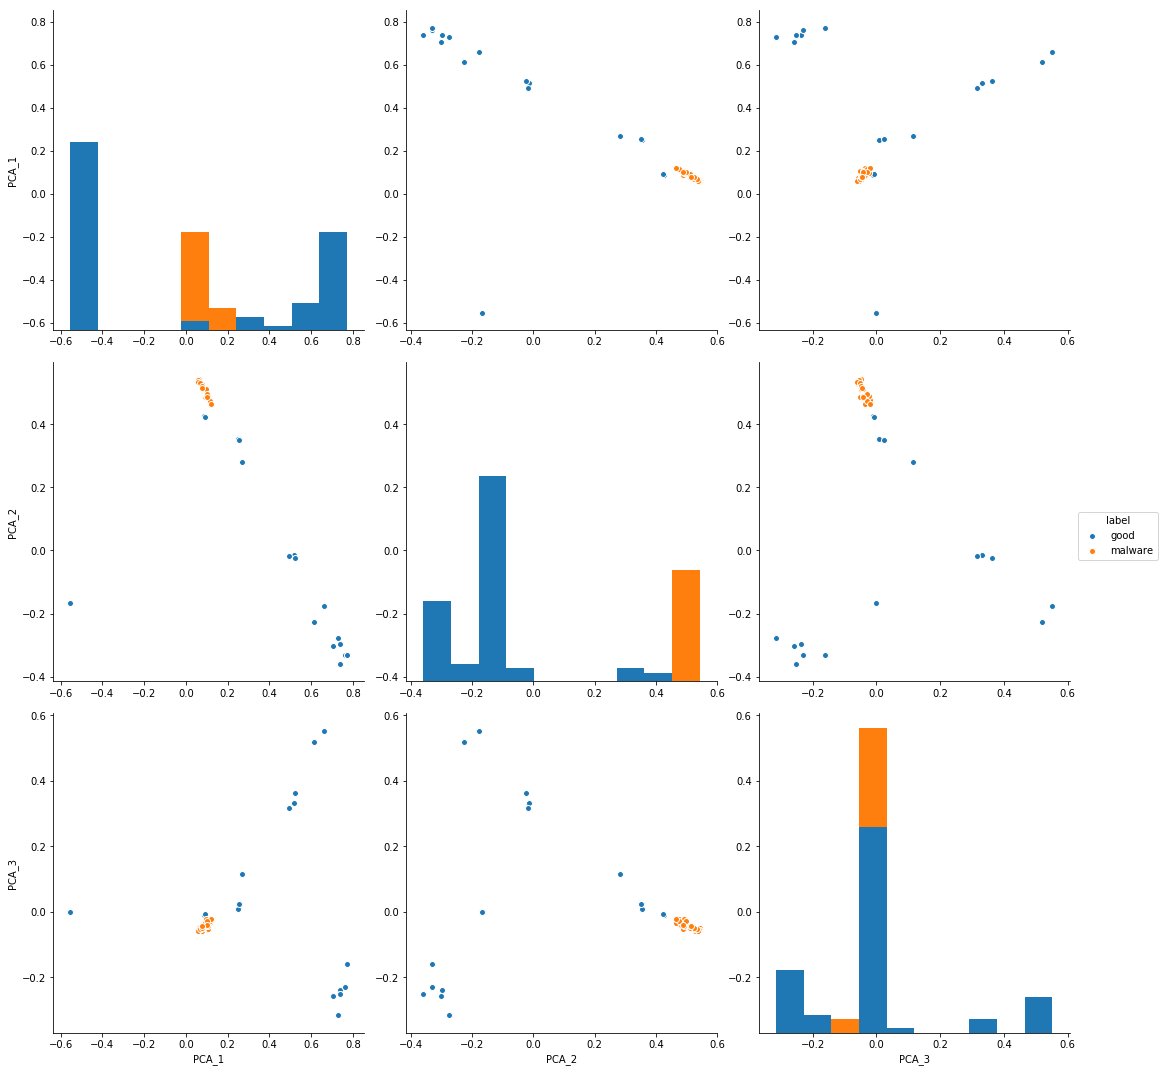

In [200]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

_tfidf = TfidfVectorizer(analyzer="char", ngram_range=(2,3))
_pca = PCA(n_components=3)

tfidf_vec = _tfidf.fit_transform(registry_X["path"] + " " + registry_X["value"])

pca_vec = pd.DataFrame(
    _pca.fit_transform(tfidf_vec.toarray()),
    columns=["PCA_1", "PCA_2", "PCA_3"]
)

registry_X["PCA_1"] = pca_vec["PCA_1"]
registry_X["PCA_2"] = pca_vec["PCA_2"]
registry_X["PCA_3"] = pca_vec["PCA_3"]

registry_X["label"] = registry_y["label"]

sns.pairplot(registry_X[["PCA_1", "PCA_2", "PCA_3", "label"]], hue="label", size=5)
plt.show()

It looks like there's some clustering we can do with this. Let's set up a pipeline for TFIDF and PCA and then classify with KNN

In [276]:
# Need to define this for TFIDF --> PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


# The to_dense pipeline is because PCA does not accept a sparse matrix
reg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('pca', PCA()),
    ('knn', KNeighborsClassifier()),
])

reg_params = {
    'tfidf__analyzer': ('word', 'char'),
    'tfidf__ngram_range': ((2, 3), ),
    'pca__n_components': (3, 4, 5),
    'knn__weights' : ("uniform", "distance"),
    "knn__n_neighbors": list(range(1, 10))
}

reg_grid = GridSearchCV(reg_pipeline, reg_params, return_train_score=False)

X = registry_X["path"] + " " + registry_X["value"]
y = registry_X["label"]

reg_grid.fit(X, y)

reg_results = pd.DataFrame(reg_grid.cv_results_)

In [277]:
reg_results.sort_values("mean_test_score", ascending=False).head(1)

,mean_fit_time,mean_score_time,mean_test_score,param_knn__n_neighbors,param_knn__weights,param_pca__n_components,param_tfidf__analyzer,param_tfidf__ngram_range,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,std_fit_time,std_score_time,std_test_score
0,0.004827,0.001881,0.980198,1,uniform,3,word,"(2, 3)","{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 3, 'tfidf__analyzer': 'word', 'tfidf__ngram_range': (2, 3)}",1,1.0,1.0,0.939394,0.000678,0.000145,0.028425


In [278]:
best_reg_clf = reg_grid.best_estimator_
best_reg_clf.__dict__

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(2, 3), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('dense', FunctionTransformer(accept_sparse=True,
             func=<function <lambda> at 0x1230b02f0>, inv_kw_args=None,
             inverse_func=None, kw_args=None, pass_y='deprecated',
             validate=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)),
  ('knn',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=1, n_neighb

Let's test our classifier. I found some malware online that sets the CurrentVersion Run key:

1. `aIYqDubteCKSoK` from https://www.hybrid-analysis.com/sample/b0270bb40d4b0919d4fb81d4c25511735e27733a897f546d74421fba4d4a13d9?environmentId=100
2. `J14b8d4004b4:U4e504645467553_s` from https://www.hybrid-analysis.com/sample/918214f15172064279d92955f866a4c3c68b57c007a8230a3b659dce1c269b64?environmentId=100

In [279]:
print(best_reg_clf.predict(["Software Microsoft Windows CurrentVersion Run aIYqDubteCKSoK"]))
print(best_reg_clf.predict(["Software Microsoft Windows CurrentVersion Run J14b8d4004b4:U4e504645467553_s"]))

['malware']
['malware']


### Aside - Overfitting and lack of sample data

It's pretty clear to anyone that has some knowledge of malware behavior that this model is not very efficient. We are only able to detect things in the run key, and we'll most likely get some false positives. 

Here's an example of the registry key that spotify sets when its installed on the machine:

In [280]:
print(best_reg_clf.predict(["Software Microsoft Windows CurrentVersion Run Spotify"]))

['malware']


Our classifier labeled this as malicious, even though it's benign. I believe that this is due to me creating only a single piece of "malware" that does something very specific. To properly be able to categorize this we will need a much larger dataset, at which point KNN might not be the best way to classify our data. 

Sadly I was not able to find a larger, publicly available dataset for this subject and had to create my own data, which was clearly not a large enough training set. 

---

## Scheduled Task Creation

Let's try to do the exact same thing for our scheduled tasks dataset

In [241]:
baseline_schtasks = baseline[(baseline.EventID == "1")].copy()
malicious_schtasks = malicious[(malicious.EventID == "1")].copy()

In [247]:
schtasks_training_data = malicious_schtasks.append(baseline_schtasks)

schtasks_training_data = clean_sysmon_df(schtasks_training_data).reset_index()

schtasks_training_data.head()

,index,Correlation,EventData_CommandLine,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,EventData_DestinationIsIpv6,EventData_DestinationPort,EventData_DestinationPortName,...,EventData_TerminalSessionId,EventData_User,EventData_UtcTime,Execution,Provider,Security,TimeCreated,TimeCreated_SystemTime,label,label_desc
0,94,None,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn 5kmwh5IJw94 /TR C:\users\admin\appdata\local\mXENWW7ugzXb.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:28:23.454,None,None,None,None,2017-12-10 02:28:23.485712,malware,scheduled task timed execution
1,95,None,schtasks.exe /create /sc onstart /tn 5kmwh5IJw94 /TR C:\users\admin\appdata\local\mXENWW7ugzXb.exe,NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:28:23.485,None,None,None,None,2017-12-10 02:28:23.501337,malware,scheduled task timed execution
2,104,None,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn YQTM6MnfTgO /TR C:\users\admin\appdata\local\OXVUKQBE42i.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:34:28.729,None,None,None,None,2017-12-10 02:34:28.776274,malware,scheduled task timed execution
3,105,None,schtasks.exe /create /sc onstart /tn YQTM6MnfTgO /TR C:\users\admin\appdata\local\OXVUKQBE42i.exe,NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:34:28.776,None,None,None,None,2017-12-10 02:34:28.791899,malware,scheduled task timed execution
4,107,None,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn lH61P1l9ZrsEAFnElIZ9z /TR C:\users\admin\appdata\local\IxGS2STpPghAjRuHS.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:37:56.618,None,None,None,None,2017-12-10 02:37:56.650150,malware,scheduled task timed execution


In here we really are only interested in the command line arguments. Let's pull that out and set that to be our features array.

In [281]:
schtasks_X = schtasks_training_data[['EventData_CommandLine', "label"]].copy()

schtasks_X['EventData_CommandLine'] = schtasks_X['EventData_CommandLine'].str.replace("\\", " ")
schtasks_X.sample(5)

,EventData_CommandLine,label
40,"C: Windows system32 cmd.exe /c ""schtasks.exe /create /sc onstart /tn y0kAMRNt0l7i /TR C: users admin appdata local xio0Ir5SmOoYitAO.exe""",malware
17,schtasks.exe /create /sc onstart /tn 947peTjIMJsLHmyh /TR C: users admin appdata local ZCIkdEQ4IxIZR8Os.exe,malware
51,"""C: Program Files (x86) Windows Media Player setup_wm.exe"" /RunOnce:""C: Program Files (x86) Windows Media Player wmplayer.exe"" /prefetch:1",good
50,"""C: Program Files (x86) Windows Media Player wmplayer.exe"" /prefetch:1",good
0,"C: Windows system32 cmd.exe /c ""schtasks.exe /create /sc onstart /tn 5kmwh5IJw94 /TR C: users admin appdata local mXENWW7ugzXb.exe""",malware


Let's do the same thing we did for our registry key classifier. TFIDF into PCA and see if it can work with a clustering algorithm again.

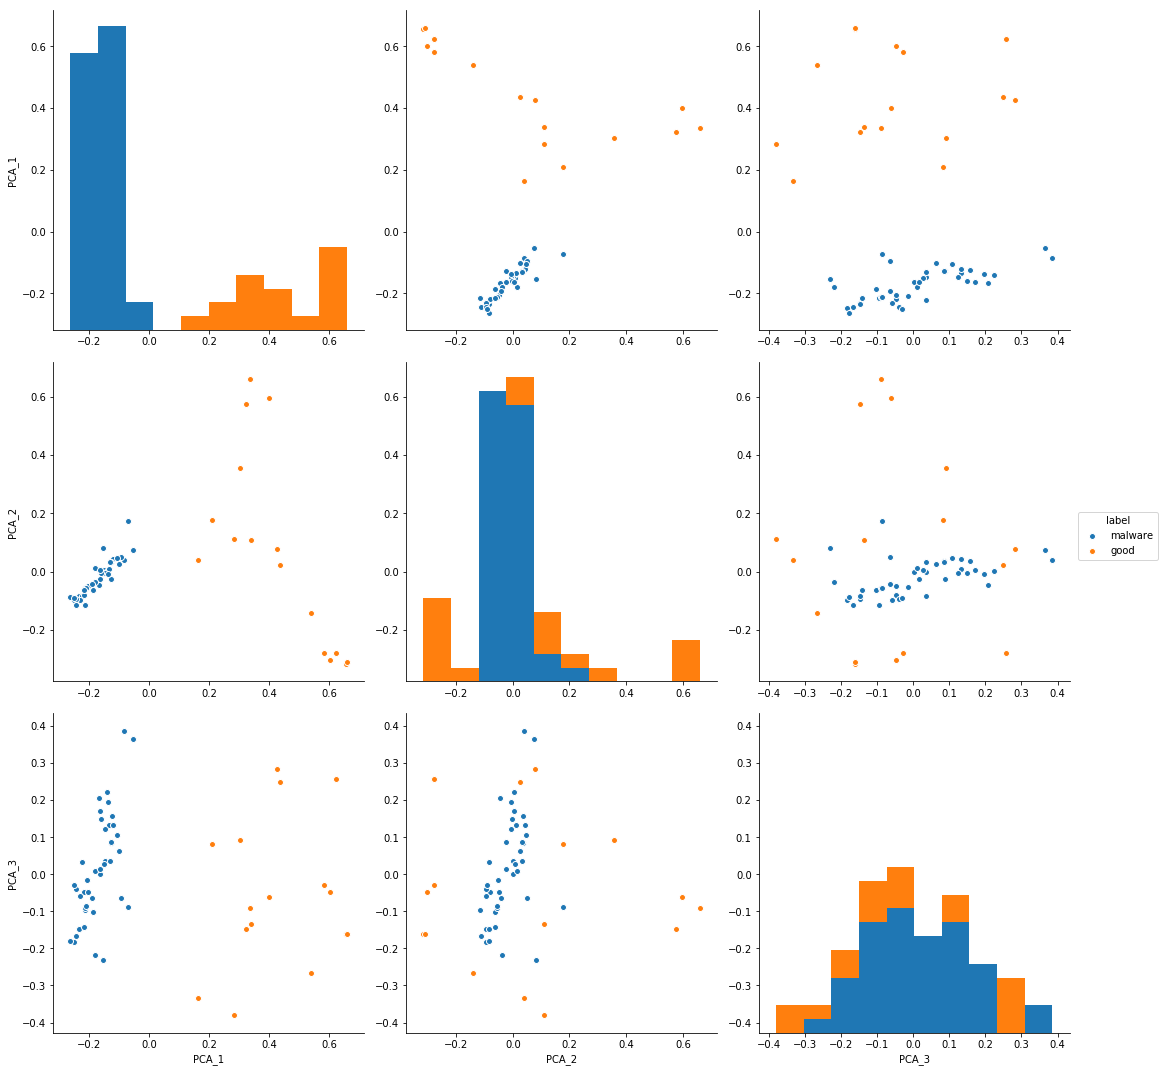

In [282]:
_tfidf = TfidfVectorizer(analyzer="char", ngram_range=(2,3))
_pca = PCA(n_components=3)

tfidf_vec = _tfidf.fit_transform(schtasks_X["EventData_CommandLine"])

pca_vec = pd.DataFrame(
    _pca.fit_transform(tfidf_vec.toarray()),
    columns=["PCA_1", "PCA_2", "PCA_3"]
)

schtasks_X["PCA_1"] = pca_vec["PCA_1"]
schtasks_X["PCA_2"] = pca_vec["PCA_2"]
schtasks_X["PCA_3"] = pca_vec["PCA_3"]

sns.pairplot(schtasks_X[["PCA_1", "PCA_2", "PCA_3", "label"]], hue="label", size=5)
plt.show()

I think this time we should use an SVM with a non-linear kernel function since the data is clearly distinguishable but not in clear clusters. Let's set up a pipeline and see what we can get.

In [283]:
from sklearn.svm import SVC
import numpy as np

# The to_dense pipeline is because PCA does not accept a sparse matrix
schtasks_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('pca', PCA()),
    ('svm', SVC()),
])

schtasks_params = {
    'tfidf__analyzer': ('word', 'char'),
    'tfidf__ngram_range': ((2, 3), ),
    'pca__n_components': (3, 4, 5),
    'svm__kernel' : ("poly", "rbf", "sigmoid"),
    "svm__C": list(np.arange(0.1, 3.0, 0.1)),
}

schtasks_grid = GridSearchCV(schtasks_pipeline, schtasks_params, return_train_score=False)

X = schtasks_X["EventData_CommandLine"]
y = schtasks_X["label"]

schtasks_grid.fit(X, y)

schtasks_results = pd.DataFrame(schtasks_grid.cv_results_)

In [284]:
schtasks_results.sort_values("mean_test_score", ascending=False).head(1)

,mean_fit_time,mean_score_time,mean_test_score,param_pca__n_components,param_svm__C,param_svm__kernel,param_tfidf__analyzer,param_tfidf__ngram_range,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,std_fit_time,std_score_time,std_test_score
146,0.005681,0.001517,0.983607,3,2.5,rbf,word,"(2, 3)","{'pca__n_components': 3, 'svm__C': 2.5, 'svm__kernel': 'rbf', 'tfidf__analyzer': 'word', 'tfidf__ngram_range': (2, 3)}",1,0.952381,1.0,1.0,0.001271,0.000192,0.022625


In [285]:
schtasks_clf = schtasks_grid.best_estimator_
schtasks_clf.__dict__

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(2, 3), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('dense', FunctionTransformer(accept_sparse=True,
             func=<function <lambda> at 0x122b2c1e0>, inv_kw_args=None,
             inverse_func=None, kw_args=None, pass_y='deprecated',
             validate=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)),
  ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf

Let's try pulling some command line arguments used by real malware. Let's try the following two samples:

1. `schtasks.exe schtasks /Create /SC ONLOGON /RL HIGHEST /RU ZfIOtiU /TN IEData140 /TR %WINDIR%\System32\IEData140\IEData140.exe ` from https://www.hybrid-analysis.com/sample/41e698c7f1febdb53b9b7eae0f48fd93949602d0631d6f6b7dc0768958f7107a?environmentId=100
2. `schtasks.exe /create /tn "ENERGON" /tr "C:\execute.bat" /sc ONSTART /ru "System" ` from https://www.hybrid-analysis.com/sample/3ca660876f48b5d54bda8898c3814e912d9cf7759a3313d0ad55578f96fc1863?environmentId=100
3. ` schtasks.exe /Create /RU system /SC ONLOGON /TN Microsoft\WindowsOptimizationsService /TR "wscript %PUBLIC%\Documents\system.vbs" /F` from https://www.hybrid-analysis.com/sample/74990a1d4f25c6b6b3edc937c5a2cd349a3f540eb66d40ee189b51e333ade77b?environmentId=100
4. `schtasks /create /sc onstart /mo 1 /tn nyan /tr %APPDATA%\Host Process for Windows Tasks.exe` from https://www.hybrid-analysis.com/sample/7c209d4541dad9c96dbef32928a5a57a6b9e48c7ab18991cf73ae80911587741?environmentId=100



In [304]:
mal_tasks = [
    "schtasks.exe schtasks /Create /SC ONLOGON /RL HIGHEST /RU ZfIOtiU /TN IEData140 /TR %WINDIR%\System32\IEData140\IEData140.exe",
    "schtasks.exe /create /tn \"ENERGON\" /tr \"C:\execute.bat\" /sc ONSTART /ru \"System\"",
    "schtasks.exe /Create /RU system /SC ONLOGON /TN Microsoft\WindowsOptimizationsService /TR \"wscript %PUBLIC%\Documents\system.vbs\" /F",
    "schtasks /create /sc onstart /mo 1 /tn nyan /tr %APPDATA%\Host Process for Windows Tasks.exe",
]

good_tasks = [
    "notepad.exe",
    "cmd.exe",
    "calc.exe",
    "WINWORD.exe",
    "onstart",
    "create",
]

results = []

for task in mal_tasks:
    pred = schtasks_clf.predict([task])[0]
    results.append({
        "pred": pred,
        "expected": "malware",
        "cmdline": task,
    })
    
for task in good_tasks:
    pred = schtasks_clf.predict([task])[0]
    results.append({
        "pred": pred,
        "expected": "good",
        "cmdline": task,
    })
    
results_df = pd.DataFrame(results)
results_df

,cmdline,expected,pred
0,schtasks.exe schtasks /Create /SC ONLOGON /RL HIGHEST /RU ZfIOtiU /TN IEData140 /TR %WINDIR%\System32\IEData140\IEData140.exe,malware,malware
1,"schtasks.exe /create /tn ""ENERGON"" /tr ""C:\execute.bat"" /sc ONSTART /ru ""System""",malware,malware
2,"schtasks.exe /Create /RU system /SC ONLOGON /TN Microsoft\WindowsOptimizationsService /TR ""wscript %PUBLIC%\Documents\system.vbs"" /F",malware,malware
3,schtasks /create /sc onstart /mo 1 /tn nyan /tr %APPDATA%\Host Process for Windows Tasks.exe,malware,malware
4,notepad.exe,good,good
5,cmd.exe,good,malware
6,calc.exe,good,good
7,WINWORD.exe,good,good
8,onstart,good,good
9,create,good,good


It looks like throwing a mix of actually malicious and non malicious command lines actuall work pretty well with this classifier.

The only false-positive was cmd.exe, and this was because if you remember, most of the training data we had on malicious scheduled tasks was seeing `cmd.exe` invoke `schtasks.exe`, which is probably why the classifier thinks this is malicious